# Cybersecurity Multiple Regression & Data Hygiene Lab (Departments)

This lab uses *synthetic* security telemetry by **department** and quarter to practice multiple regression and assumptions checking.

**Learning goals**
- Data cleaning: missingness, impossible values, and type issues
- Feature engineering: transformations, interactions, confounders
- Fit OLS via `statsmodels` formula API
- Diagnose assumptions: linearity, normality, constant variance, multicollinearity
- Influence & outliers: leverage, Cook's distance
- Goodness of fit: $R^2$, adj. $R^2$, AIC/BIC, RMSE; train/test generalization


In [31]:

# Setup
import numpy as np, pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
import altair as alt
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option("display.float_format", lambda x: f"{x:0.3f}")
data_path = Path("cybersec.csv")  # put this notebook in same folder as the CSV
df = pd.read_csv(data_path)
df.head()


,department,quarter,org_size,it_budget_per_emp,mfa_coverage,endpoint_coverage,vuln_count,mean_time_to_patch,phishing_sim_click_rate,training_completion_rate,login_failures_per_user,cloud_misconfig_count,security_incidents
0,Customer Support,Q4-2024,4069,5021.120,0.615,0.543,109.000,24.200,0.880,0.112,2.220,9,13
1,Sales,Q1-2023,25000,4739.000,0.990,0.661,144.000,50.500,0.780,0.093,1.450,3,12
2,Customer Support,Q1-2023,4069,5021.120,0.615,0.612,102.000,40.400,0.890,0.154,2.910,5,10
3,Facilities,Q1-2024,3569,4771.560,0.904,0.751,91.000,12.800,0.560,0.178,2.850,9,9
4,Logistics,Q4-2024,4198,4013.220,0.767,0.877,117.000,62.700,0.640,0.224,2.600,5,8


## 1) Quick EDA & Data Hygiene

In [32]:

# Inspect dtypes and basic ranges
display(df.info())
df.describe(include="all").T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   department                240 non-null    object 
 1   quarter                   240 non-null    object 
 2   org_size                  240 non-null    int64  
 3   it_budget_per_emp         240 non-null    float64
 4   mfa_coverage              240 non-null    float64
 5   endpoint_coverage         240 non-null    float64
 6   vuln_count                235 non-null    float64
 7   mean_time_to_patch        240 non-null    float64
 8   phishing_sim_click_rate   240 non-null    float64
 9   training_completion_rate  225 non-null    float64
 10  login_failures_per_user   240 non-null    float64
 11  cloud_misconfig_count     240 non-null    int64  
 12  security_incidents        240 non-null    int64  
dtypes: float64(8), int64(3), object(2)
memory usage: 24.5+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
department,240,30,Customer Support,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quarter,240,8,Q4-2024,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
org_size,240.000,NaN,NaN,NaN,2576.558,2133.880,178.000,958.000,2353.000,4073.000,25000.000
it_budget_per_emp,240.000,NaN,NaN,NaN,4402.104,637.965,2916.580,4013.220,4408.135,4771.560,5582.310
mfa_coverage,240.000,NaN,NaN,NaN,0.780,0.110,0.572,0.725,0.770,0.840,0.990
endpoint_coverage,240.000,NaN,NaN,NaN,0.847,0.077,0.543,0.814,0.849,0.886,0.970
vuln_count,235.000,NaN,NaN,NaN,59.391,40.401,2.000,22.500,55.000,92.000,150.000
mean_time_to_patch,240.000,NaN,NaN,NaN,42.139,12.868,1.000,33.375,43.250,50.500,78.700
phishing_sim_click_rate,240.000,NaN,NaN,NaN,0.242,0.232,0.016,0.115,0.191,0.311,1.550
training_completion_rate,225.000,NaN,NaN,NaN,0.731,0.147,0.093,0.663,0.735,0.829,0.990


In [33]:

# Identify issues: percentages outside [0,1], text in numeric fields, missingness pattern
problem_rows = df[
    (df['phishing_sim_click_rate']>1) | (df['phishing_sim_click_rate']<0) |
    (df['training_completion_rate']>1) | (df['training_completion_rate']<0)
]
print("Bad percentage rows:", len(problem_rows))

# Fix 'vuln_count' coerced to numeric; identify NAs introduced
df['vuln_count'] = pd.to_numeric(df['vuln_count'], errors='coerce')

# Clip impossible rates
df['training_completion_rate'] = df['training_completion_rate'].clip(0,1)
df['phishing_sim_click_rate'] = df['phishing_sim_click_rate'].clip(0,1)

# Impute: forward fill by department then overall median as fallback
df = df.sort_values(['department','quarter'])
df['training_completion_rate'] = df.groupby('department')['training_completion_rate'].ffill()
df['training_completion_rate'] = df['training_completion_rate'].fillna(df['training_completion_rate'].median())

# Remaining missing
df.isna().mean().sort_values(ascending=False)


Bad percentage rows: 7


vuln_count                 0.021
department                 0.000
quarter                    0.000
org_size                   0.000
it_budget_per_emp          0.000
mfa_coverage               0.000
endpoint_coverage          0.000
mean_time_to_patch         0.000
phishing_sim_click_rate    0.000
training_completion_rate   0.000
login_failures_per_user    0.000
cloud_misconfig_count      0.000
security_incidents         0.000
dtype: float64

In [34]:

# Altair visual checks
base = alt.Chart(df)

# Incidents histogram
alt.Chart(df).mark_bar().encode(
    x=alt.X('security_incidents:Q', bin=alt.Bin(maxbins=30), title='Security incidents'),
    y=alt.Y('count()', title='Count')
).properties(width=350, height=250)

# Incidents vs vulnerabilities
base.mark_circle(opacity=0.6).encode(
    x='vuln_count:Q',
    y='security_incidents:Q',
    tooltip=['department','quarter','vuln_count','security_incidents']
).properties(title='Incidents vs Vulns', width=350, height=250)

# Incidents vs patch time
base.mark_circle(opacity=0.6).encode(
    x='mean_time_to_patch:Q',
    y='security_incidents:Q',
    tooltip=['department','quarter','mean_time_to_patch','security_incidents']
).properties(title='Incidents vs Patch Time', width=350, height=250)


alt.Chart(...)

## 2) Feature Engineering & Confounders

In [35]:

# Confounders: org_size and it_budget_per_emp likely affect both controls and incidents.
df['log_org_size'] = np.log1p(df['org_size'])
df['log_vulns'] = np.log1p(df['vuln_count'])
df['misconfig_rate'] = df['cloud_misconfig_count'] / (df['org_size']/1000)
df['vuln_x_endpoint_gap'] = df['vuln_count'] * (1 - df['endpoint_coverage'])

df[['department','org_size','log_org_size','vuln_count','log_vulns','misconfig_rate','vuln_x_endpoint_gap']].head()


,department,org_size,log_org_size,vuln_count,log_vulns,misconfig_rate,vuln_x_endpoint_gap
182,Accounting,474,6.163,10.000,2.398,6.329,1.350
186,Accounting,474,6.163,8.000,2.197,2.110,1.080
183,Accounting,474,6.163,7.000,2.079,12.658,0.945
187,Accounting,474,6.163,10.000,2.398,16.878,1.350
184,Accounting,474,6.163,8.000,2.197,4.219,1.080


## 3) Baseline OLS (naïve model)

In [36]:

# Naïve model: omit confounders/transformations to illustrate bias
formula0 = 'security_incidents ~ vuln_count + mean_time_to_patch + phishing_sim_click_rate + cloud_misconfig_count'
m0 = smf.ols(formula0, data=df).fit()
print(m0.summary())


                            OLS Regression Results                            
Dep. Variable:     security_incidents   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     19.01
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           1.60e-13
Time:                        11:13:07   Log-Likelihood:                -449.28
No. Observations:                 235   AIC:                             908.6
Df Residuals:                     230   BIC:                             925.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## 4) Improved OLS with Confounders, Transformations & Interactions

In [37]:

formula1 = '''
security_incidents ~ log_vulns + mean_time_to_patch + phishing_sim_click_rate
+ login_failures_per_user + cloud_misconfig_count
+ mfa_coverage + endpoint_coverage + training_completion_rate
+ log_org_size + it_budget_per_emp
+ vuln_x_endpoint_gap
'''
m1 = smf.ols(" ".join(formula1.split()), data=df).fit()
print(m1.summary())


                            OLS Regression Results                            
Dep. Variable:     security_incidents   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     35.91
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           2.08e-43
Time:                        11:13:07   Log-Likelihood:                -363.07
No. Observations:                 235   AIC:                             750.1
Df Residuals:                     223   BIC:                             791.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## 5) Assumptions Diagnostics

In [38]:

# Multicollinearity (VIF)
import pandas as pd
X = m1.model.exog
vif = pd.DataFrame({
    "feature": m1.model.exog_names,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})
vif


,feature,VIF
0,Intercept,759.951
1,log_vulns,18.600
2,mean_time_to_patch,1.264
3,phishing_sim_click_rate,1.116
4,login_failures_per_user,1.045
5,cloud_misconfig_count,1.221
6,mfa_coverage,1.097
7,endpoint_coverage,2.668
8,training_completion_rate,1.298
9,log_org_size,17.712


In [39]:

# Residuals vs Fitted (Altair)
resid = m1.resid
fitted = m1.fittedvalues
rdf = pd.DataFrame({"fitted": fitted, "resid": resid})

alt.Chart(rdf).mark_circle(opacity=0.6).encode(
    x='fitted:Q', y='resid:Q'
).properties(title='Residuals vs Fitted', width=400, height=280)


alt.Chart(...)

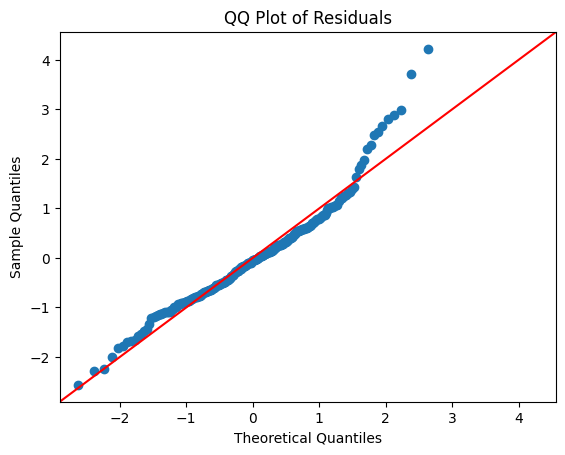

In [40]:

# QQ Plot (statsmodels uses matplotlib; it's a standard diagnostic that works well)
sm.qqplot(resid, line='45', fit=True)
plt.title('QQ Plot of Residuals')
plt.show()


In [41]:

# Normality & homoscedasticity tests
jb_p = sm.stats.jarque_bera(resid)[1]
ad_stat, ad_p = normal_ad(resid)
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(resid, m1.model.exog)
bp_labels = ['LM stat','LM p-value','F stat','F p-value']

print("Jarque-Bera p:", jb_p)
print("Anderson-Darling p:", ad_p)
print(dict(zip(bp_labels, bp_test)))


Jarque-Bera p: 5.579190766152953e-17
Anderson-Darling p: 1.0267210999876215e-05
{'LM stat': np.float64(53.968843466023465), 'LM p-value': np.float64(1.1959138340595085e-07), 'F stat': np.float64(6.043686986034689), 'F p-value': np.float64(1.2359682140988446e-08)}


## 6) Influence & Outliers

In [42]:

infl = m1.get_influence()
summary_frame = infl.summary_frame()
summary_frame[['standard_resid','hat_diag','cooks_d']].sort_values('cooks_d', ascending=False).head(10)


,standard_resid,hat_diag,cooks_d
0,2.816,0.220,0.187
1,1.516,0.353,0.105
3,2.909,0.121,0.097
4,3.064,0.096,0.083
5,4.220,0.051,0.079
205,-2.063,0.110,0.044
172,-1.774,0.122,0.037
222,-2.315,0.073,0.035
15,2.674,0.056,0.035
36,-1.868,0.106,0.035


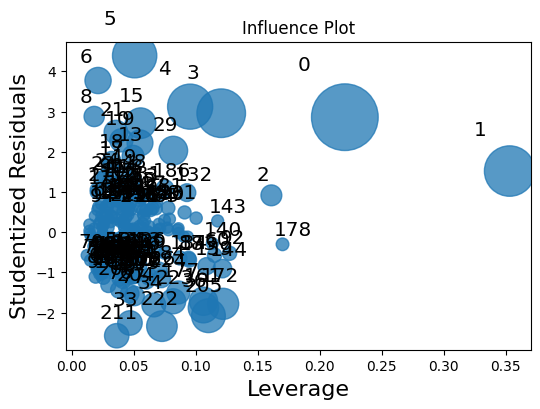

In [43]:

# Influence plot (matplotlib via statsmodels)
fig, ax = plt.subplots(figsize=(6,4))
sm.graphics.influence_plot(m1, criterion="cooks", ax=ax, alpha=0.6)
plt.title("Influence Plot")
plt.show()


## 7) Refit after Addressing Issues

In [44]:

# Example rule: drop points with Cook's D > 4/n
n = df.shape[0]
cook_cut = 4/n
# keep_mask = summary_frame['cooks_d'] < cook_cut
# df_refit = df.loc[keep_mask].copy()

df_refit = df.copy()

m2 = smf.ols(" ".join(formula1.split()), data=df_refit).fit()
print(m2.summary())
print("\nCompare models:")
print(pd.DataFrame({
    "model": ["m0 (naive)","m1 (full)","m2 (refit)"],
    "n": [m0.nobs, m1.nobs, m2.nobs],
    "Adj R^2": [m0.rsquared_adj, m1.rsquared_adj, m2.rsquared_adj],
    "AIC": [m0.aic, m1.aic, m2.aic],
    "BIC": [m0.bic, m1.bic, m2.bic],
}))


                            OLS Regression Results                            
Dep. Variable:     security_incidents   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     35.91
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           2.08e-43
Time:                        11:13:07   Log-Likelihood:                -363.07
No. Observations:                 235   AIC:                             750.1
Df Residuals:                     223   BIC:                             791.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## 8) Train/Test Generalization

In [45]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

features = ['log_vulns','mean_time_to_patch','phishing_sim_click_rate',
            'login_failures_per_user','cloud_misconfig_count','mfa_coverage',
            'endpoint_coverage','training_completion_rate','log_org_size',
            'it_budget_per_emp','vuln_x_endpoint_gap']

train, test = train_test_split(df_refit, test_size=0.25, random_state=123)

m_train = smf.ols('security_incidents ~ ' + ' + '.join(features), data=train).fit()
pred = m_train.predict(test[features])
rmse = mean_squared_error(test['security_incidents'], pred, squared=False)
print(f"Test RMSE: {rmse:0.3f}")


/Users/paulboal/.pyenv/versions/data5740/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ValueError: Input contains NaN.

## 9) Instructor Prompts / Discussion

- **Confounders:** What happens to coefficients if `log_org_size` and `it_budget_per_emp` are omitted?
- **Linearity:** Try polynomial or spline terms for `mean_time_to_patch`—does the residual pattern improve?
- **Normality:** If residuals are heavy-tailed, try a robust regression (`smf.rlm`)—how do inferences change?
- **Constant Variance:** Apply a Box-Cox or log transform on `security_incidents+1` and refit. Compare BP test.
- **Outliers:** Which observations drive large Cook’s D? Are they data errors or real but rare cases?
- **Goodness of Fit:** Compare adj. $R^2$, AIC/BIC, and test RMSE. Which model would you ship?
